In [4]:
# packages, which we will need
import pandas as pd
import numpy as np
import random as rnd
import json
import plotly.graph_objs as go
from plotly import tools
import plotly.plotly as py

import plotly
plotly.tools.set_credentials_file(username='samohorvath', api_key='Cktics00RkleClssDDdB')

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gc
import sys

from pandas.io.json import json_normalize
from datetime import datetime
from sklearn import preprocessing

import os

In [5]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [6]:
%%time
train = load_df('train.csv')
test = load_df('test.csv')

print('train date:', min(train['date']), 'to', max(train['date']))
print('test date:', min(test['date']), 'to', max(test['date']))

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
train date: 20160801 to 20170801
test date: 20170802 to 20180430
CPU times: user 2min 52s, sys: 10 s, total: 3min 2s
Wall time: 3min 2s


In [7]:
# only train feature
for c in train.columns.values:
    if c not in test.columns.values: print(c)

totals.transactionRevenue
trafficSource.campaignCode


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null int64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device.browser                                       903653 non-null object
device.browserSize                                   903653 non-null object
device.browserVersion                                903653 non-null object
device.deviceCategory                                9036

In [9]:
train.head()

channelGrouping      date        fullVisitorId  \
0  Organic Search  20160902  1131660440785968503   
1  Organic Search  20160902   377306020877927890   
2  Organic Search  20160902  3895546263509774583   
3  Organic Search  20160902  4763447161404445595   
4  Organic Search  20160902    27294437909732085   

                        sessionId  socialEngagementType     visitId  \
0  1131660440785968503_1472830385  Not Socially Engaged  1472830385   
1   377306020877927890_1472880147  Not Socially Engaged  1472880147   
2  3895546263509774583_1472865386  Not Socially Engaged  1472865386   
3  4763447161404445595_1472881213  Not Socially Engaged  1472881213   
4    27294437909732085_1472822600  Not Socially Engaged  1472822600   

   visitNumber  visitStartTime device.browser             device.browserSize  \
0            1      1472830385         Chrome  not available in demo dataset   
1            1      1472880147        Firefox  not available in demo dataset   
2            1      1472865386         Chrome  not available in demo dataset   
3            1      1472881213     UC Browser  not available in demo dataset   
4            2      1472822600         Chrome  not available in demo dataset   

          ...          trafficSource.adwordsClickInfo.isVideoAd  \
0         ...                                               NaN   
1         ...                                               NaN   
2         ...                                               NaN   
3         ...                                               NaN   
4         ...                                               NaN   

  trafficSource.adwordsClickInfo.page trafficSource.adwordsClickInfo.slot  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                                 NaN   
4                                 NaN                                 NaN   

   trafficSource.campaign trafficSource.campaignCode  \
0               (not set)                        NaN   
1               (not set)                        NaN   
2               (not set)                        NaN   
3               (not set)                        NaN   
4               (not set)                        NaN   

  trafficSource.isTrueDirect trafficSource.keyword trafficSource.medium  \
0                        NaN        (not provided)              organic   
1                        NaN        (not provided)              organic   
2                        NaN        (not provided)              organic   
3                        NaN       google + online              organic   
4                       True        (not provided)              organic   

  trafficSource.referralPath trafficSource.source  
0                        NaN               google  
1                        NaN               google  
2                        NaN               google  
3                        NaN               google  
4                        NaN               google  

[5 rows x 55 columns]

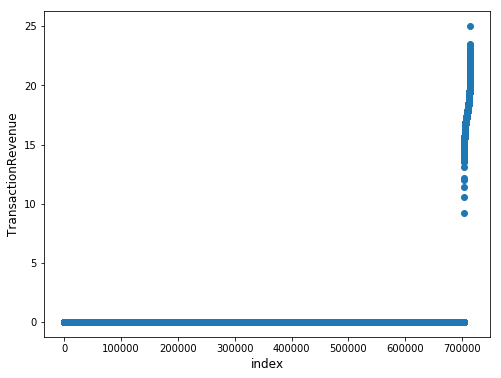

In [10]:
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')
gdf = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [11]:
nzi = pd.notnull(train["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  11515  and ratio is :  0.0127427231470487
Number of unique customers with non-zero revenue :  9996 and the ratio is :  0.013996726255903731


In [12]:
print("Number of unique visitors in train set : ",train.fullVisitorId.nunique(), " out of rows : ",train.shape[0])
print("Number of unique visitors in test set : ",test.fullVisitorId.nunique(), " out of rows : ",test.shape[0])
print("Number of common visitors in train and test set : ",len(set(train.fullVisitorId.unique()).intersection(set(test.fullVisitorId.unique())) ))

Number of unique visitors in train set :  714167  out of rows :  903653
Number of unique visitors in test set :  617242  out of rows :  804684
Number of common visitors in train and test set :  7679


In [13]:
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [14]:
print("Variables not in test but in train : ", set(train.columns).difference(set(test.columns)))

Variables not in test but in train :  {'trafficSource.campaignCode', 'totals.transactionRevenue'}


In [15]:
cols_to_drop = const_cols + ['sessionId']

train = train.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test= test.drop(cols_to_drop, axis=1)

In [16]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~samohorvath/0 or inside your plot.ly account where it is named 'device-plots'


In [17]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

train['date'] = train['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = train.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [18]:
test['date'] = test['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = test.groupby('date')['fullVisitorId'].size()


trace = scatter_plot(cnt_srs, 'red')

layout = go.Layout(
    height=400,
    width=800,
    paper_bgcolor='rgb(233,233,233)',
    title='Dates in Test set'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In [19]:
# Continent
cnt_srs = train.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = train.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [20]:
# Page views
cnt_srs = train.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

# Hits
cnt_srs = train.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'black')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'black')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='visitor-profile-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [21]:
# Impute 0 for missing target values
train["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train["totals.transactionRevenue"].values
train_id = train["fullVisitorId"].values
test_id = test["fullVisitorId"].values


# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))


num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

# Split the train dataset into development and valid based on time 
dev = train[train['date']<=datetime.date(2017,5,31)]
val = train[train['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev["totals.transactionRevenue"].values)
val_y = np.log1p(val["totals.transactionRevenue"].values)

dev_X = dev[cat_cols + num_cols] 
val_X = val[cat_cols + num_cols] 
test_X = test[cat_cols + num_cols] 

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [26]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69586
[200]	valid_0's rmse: 1.69126
[300]	valid_0's rmse: 1.69175
Early stopping, best iteration is:
[254]	valid_0's rmse: 1.69087


In [25]:
import lightgbm as lgb

In [29]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.709925685736863


In [30]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

In [31]:
sub_df.head()

fullVisitorId  PredictedLogRevenue
0  0000000259678714014             0.516011
1  0000049363351866189             0.000000
2  0000053049821714864             0.007906
3  0000059488412965267             0.048398
4  0000085840370633780             0.011108

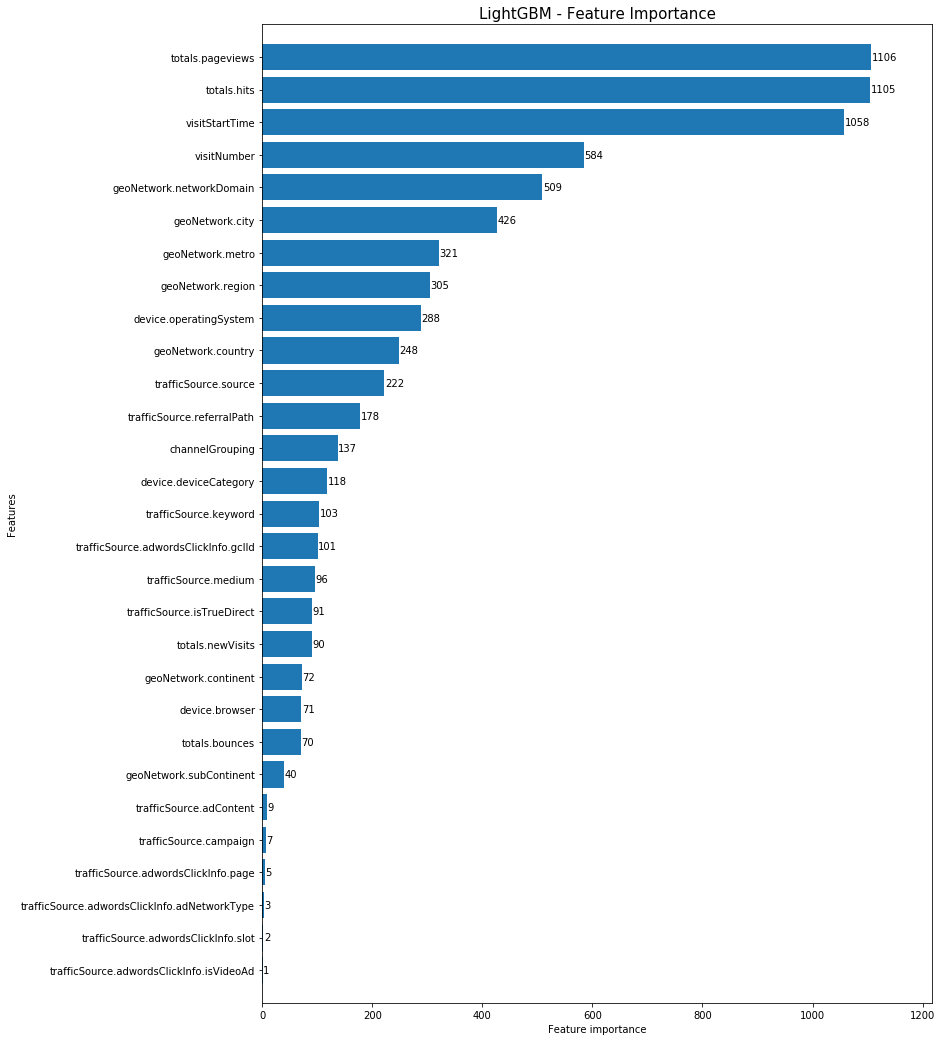

In [32]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### Old project

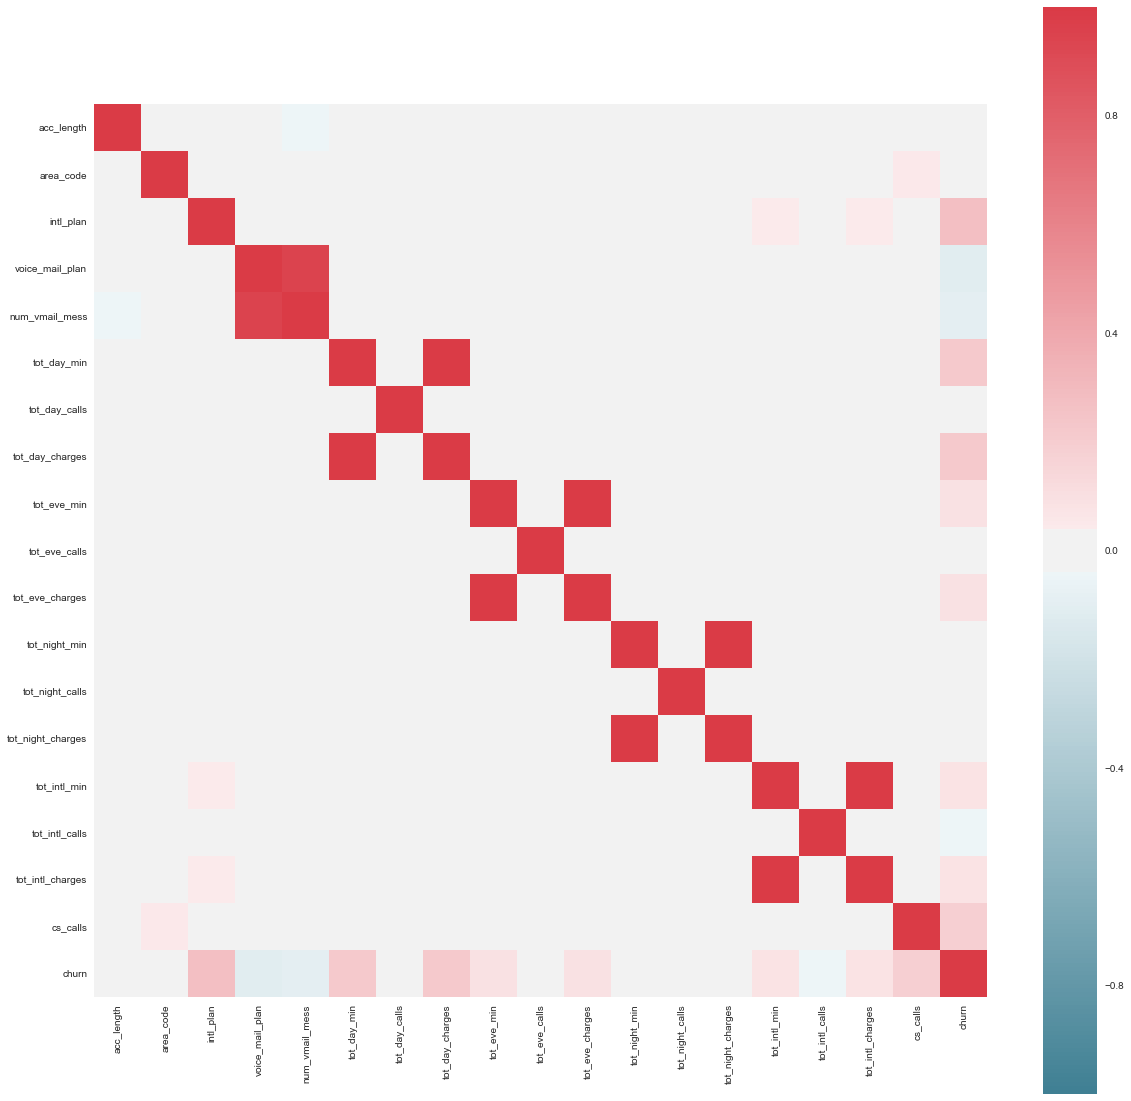

In [5]:
# Constructing Correlation matrix
f, ax = plt.subplots(figsize=(20, 20))
corr = train_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

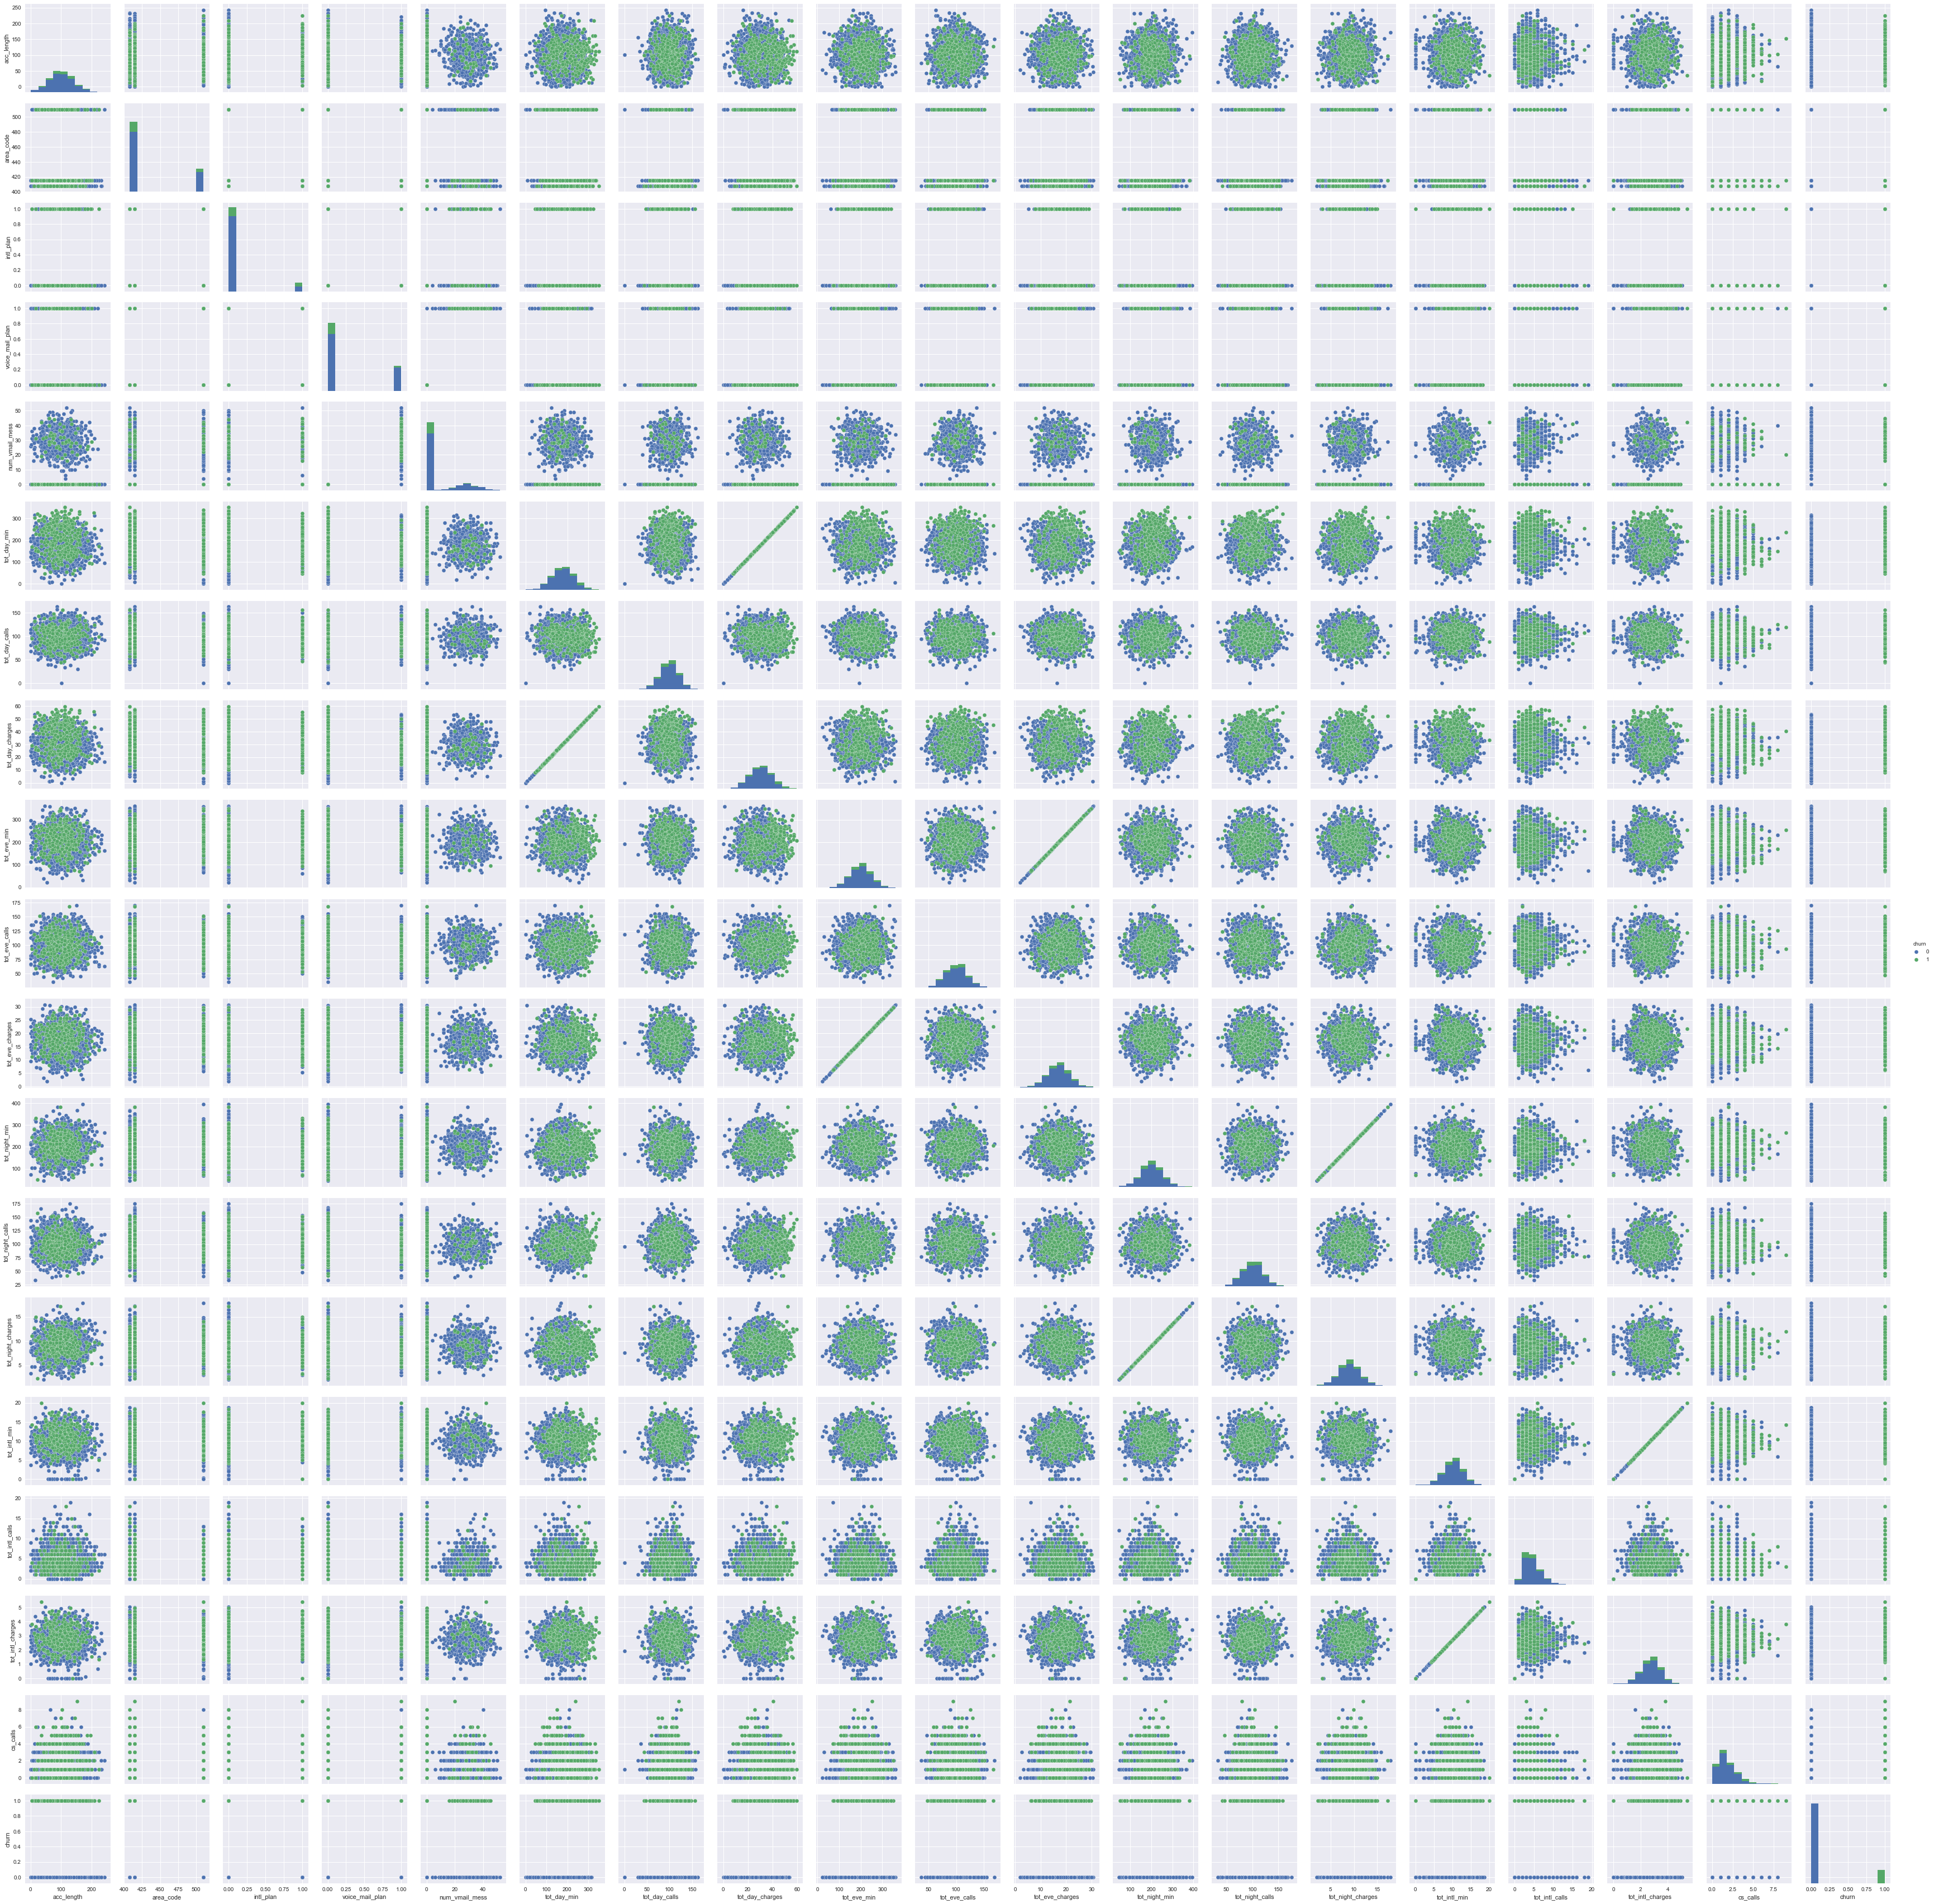

In [6]:
# Data Visualization
g = sns.pairplot(train_df.drop(["state","phone_num"], axis = 1), hue="churn")

Looking into correlation and pair plot we can see that charges are the same for everybody, so it does not make sense to include minutes and total charges, so we drop all information about minutes, because it does not provide any added value to our model because it is just multiplier of charges. We can see very large correlation between mail plan and number of voice mails, what makes sense since if you don’t have voice mail your number of voice mails is zero. For now, we will keep both features. Another observation can be that there are not two features, which are really sufficient in order to distinguish between churn and no churn customers, because we can't separate churns easily (this can be seen in pair plot). Correlation matrix show us that there is high correlation between response and number of customer support calls, day charges, international calls, which suggests that probably these are the strong features, which have the most impact on the churn. We also noted that our response is skewed with low number of churns, so it suggests that if we want to predict churns accurately, total accuracy is not a good measure, because just by predicting non-churn our total accuracy is high (~86%), instead we use Area Under Curve, which is more appropriate for correctly predicting the churn. Another possible measure could be F1-score.

In [7]:
# dropping some features and constructing response 
X_train = train_df.drop(["churn","phone_num","tot_day_min","tot_night_min",
                         "tot_eve_min", "tot_intl_min"], axis=1)
Y_train = train_df["churn"]
X_test  = test_df.drop(["churn","phone_num","tot_day_min","tot_night_min",
                         "tot_eve_min", "tot_intl_min"], axis=1)
Y_test = test_df["churn"]

In [8]:
X_train.head()

state  acc_length  area_code  intl_plan  voice_mail_plan  num_vmail_mess  \
4199    WA          70        415          0                0               0   
3429    IL         103        408          0                0               0   
3493    MS         108        415          0                1              28   
1621    SC         138        510          0                1              21   
2809    CO         156        408          0                0               0   

      tot_day_calls  tot_day_charges  tot_eve_calls  tot_eve_charges  \
4199            110            38.98             89            10.05   
3429             81            25.04             88            13.46   
3493            117            37.62            102            13.26   
1621            149             3.32            109            11.98   
2809            106            25.59            112            13.00   

      tot_night_calls  tot_night_charges  tot_intl_calls  tot_intl_charges  \
4199              105               6.98               4              2.13   
3429              103               8.72               3              2.97   
3493               80               7.17               3              2.35   
1621              111               8.09               1              2.13   
2809               86               9.72               3              0.95   

      cs_calls  
4199         1  
3429         2  
3493         0  
1621         0  
2809         1

Here, we create dummy variables for categorical data and then we normalize all the data in order to get comparable result.

In [9]:
# dummy variables for categorical data
X_train = pd.get_dummies(X_train, columns = ["state","area_code"])
X_test = pd.get_dummies(X_test, columns = ["state","area_code"])

X_scaled_train = preprocessing.scale(X_train)
X_scaled_test = preprocessing.scale(X_test)


In [10]:
X_train.head()

acc_length  intl_plan  voice_mail_plan  num_vmail_mess  tot_day_calls  \
4199          70          0                0               0            110   
3429         103          0                0               0             81   
3493         108          0                1              28            117   
1621         138          0                1              21            149   
2809         156          0                0               0            106   

      tot_day_charges  tot_eve_calls  tot_eve_charges  tot_night_calls  \
4199            38.98             89            10.05              105   
3429            25.04             88            13.46              103   
3493            37.62            102            13.26               80   
1621             3.32            109            11.98              111   
2809            25.59            112            13.00               86   

      tot_night_charges      ...        state_UT  state_VA  state_VT  \
4199               6.98      ...               0         0         0   
3429               8.72      ...               0         0         0   
3493               7.17      ...               0         0         0   
1621               8.09      ...               0         0         0   
2809               9.72      ...               0         0         0   

      state_WA  state_WI  state_WV  state_WY  area_code_408  area_code_415  \
4199         1         0         0         0              0              1   
3429         0         0         0         0              1              0   
3493         0         0         0         0              0              1   
1621         0         0         0         0              0              0   
2809         0         0         0         0              1              0   

      area_code_510  
4199              0  
3429              0  
3493              0  
1621              1  
2809              0  

[5 rows x 67 columns]

## Logistic regression

We will use logistic regression in order to better understand data. We know that logistic regression cannot capture nonlinearity, because it is linear classifier, but it is still useful, when we want to have some insights into data. For instance, which features drive churn the most or which features are probably irrelevant. We use L1 penalty in order to get sparse solution because of high number of dummy variables. To select good penalty parameter and prevent overfitting, we use validation set (20% of training data).

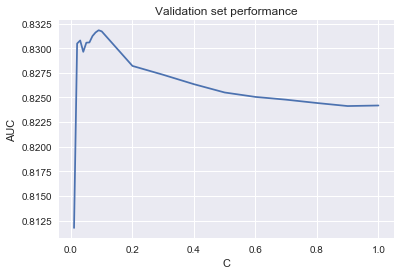

In [30]:
# Logistic regression with validation set
pen = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
train_X_scaled_train, val_X_scaled_train, train_Y_train, val_Y_train = train_test_split(X_scaled_train, Y_train,test_size=0.2)

auc_arr = np.zeros(len(pen))
b_logreg = 'NA'
max_AUC = 0

# parameter selection
for i in range(len(pen)):
    logreg = LogisticRegression( penalty = 'l1', C=pen[i])
    logreg.fit(train_X_scaled_train, train_Y_train)
    fpr, tpr, thresholds = roc_curve(val_Y_train, logreg.predict_proba(val_X_scaled_train)[:,1])
    logit_auc = auc(fpr, tpr)
    if logit_auc > max_AUC:
        b_logreg = logreg
        max_AUC = logit_auc
    auc_arr[i] = logit_auc
    
plt.plot(pen,auc_arr)
plt.ylabel('AUC')
plt.xlabel('C')
plt.title('Validation set performance')
plt.show()

b_logreg.fit(X_scaled_train, Y_train) # training on whole train dataset

In [31]:
# Coefficients with names
res = pd.DataFrame(data = {'names':X_train.columns, 'values': b_logreg.coef_[0]})
for i in range(len(res.values)):
    print( res.values[i])


['acc_length' -0.036005199759794465]
['intl_plan' 0.5740225657301514]
['voice_mail_plan' -0.36600093973642933]
['num_vmail_mess' 0.0]
['tot_day_calls' 0.0]
['tot_day_charges' 0.6861490950863035]
['tot_eve_calls' 0.0]
['tot_eve_charges' 0.2902989611002999]
['tot_night_calls' 0.0]
['tot_night_charges' 0.08208737013430334]
['tot_intl_calls' -0.09206798388951164]
['tot_intl_charges' 0.26616187882247333]
['cs_calls' 0.5349673761141377]
['state_AK' -0.002422471526429076]
['state_AL' -0.015216617635952119]
['state_AR' 0.0]
['state_AZ' 0.0]
['state_CA' 0.021245779609512752]
['state_CO' -0.012043026656140722]
['state_CT' -0.008272450578280341]
['state_DC' 0.0]
['state_DE' -0.0028021909964052526]
['state_FL' 0.0]
['state_GA' -0.025912528310606347]
['state_HI' 0.0]
['state_IA' 0.0]
['state_ID' 0.0]
['state_IL' 0.0]
['state_IN' -0.007583062822481228]
['state_KS' 0.0]
['state_KY' 0.0]
['state_LA' 0.0]
['state_MA' 0.014084668224152688]
['state_MD' 0.043013626868947004]
['state_ME' 0.0118713321679612

As we could probably assume, there is significant effect of charges on the churn. Higher charges imply that probability of churn goes up. Also, international plan has effect on churn probability. We can also see that states and area code are probably not so important, because of their almost negligible values comparing to other coefficients such as charges or international plan. Unfortunately, we can't test statistical significance because our data matrix is not full rank matrix due to dummy variables. However, since we normalized data before, thus these coefficients are comparable, so as one approach, we train our next model without area and state data, which simplifies model (-50+ features) and as we will see, it has at least the same performance.

Train precision:  87.0
Test precision:  86.44


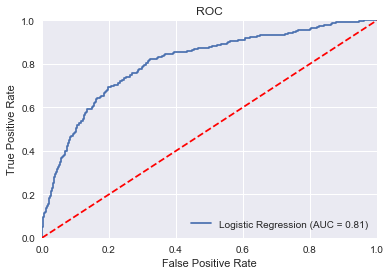

In [32]:
# Plotting the best ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, b_logreg.predict_proba(X_scaled_test)[:,1])
logit_auc = auc(fpr, tpr)

acc_logreg_train = round(b_logreg.score(X_scaled_train, Y_train) * 100, 2)
print("Train precision: " ,acc_logreg_train)
acc_logreg_test = round(b_logreg.score(X_scaled_test, Y_test) * 100, 2)
print("Test precision: " ,acc_logreg_test)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % logit_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

For the logistic regression our estimated AUC is 81%.
## Tree based method
### Decision Tree
Our second approach is also very good interpretable. In addition, it can capture nonlinearity, so the resulting model can be better in prediction. In order to prevent overfitting, we use validation set to choose the best model, where we change parameters for maximal depth, maximum number of leaf nodes, minimum number of samples in one leaf and minimum samples to make a split and then choose the best in terms of AUC criterion. We will also consider the case, where we leave out location information based on our previous results.

In [35]:
# Decision Tree with best tree
# validation set
train_X_scaled_train, val_X_scaled_train, train_Y_train, val_Y_train = train_test_split(X_scaled_train, Y_train,test_size=0.2)

depth = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
leaf_nodes = [10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
samples = [5,10,15,20]
split = [5,10,20,30,40,50]
b_auc = 0
b_decision_tree = 'NA'

# parameter selection
for d in depth:
    for leaf in leaf_nodes:
        for sample in samples:
            for spl in split:
                decision_tree = DecisionTreeClassifier(max_depth = d, max_leaf_nodes= leaf,
                                                       min_samples_split=spl,splitter='random',
                                                      min_samples_leaf=sample)
                decision_tree.fit(train_X_scaled_train, train_Y_train)
                fpr, tpr, thresholds = roc_curve(val_Y_train, decision_tree.predict_proba(val_X_scaled_train)[:,1])
                decision_tree_auc = auc(fpr, tpr)
                if decision_tree_auc > b_auc:
                    b_decision_tree = decision_tree
                    b_auc = decision_tree_auc
                    
b_decision_tree.fit(X_scaled_train, Y_train) # training on whole data

Train precision:  94.44
Test precision:  92.08


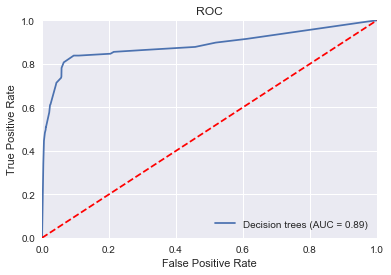

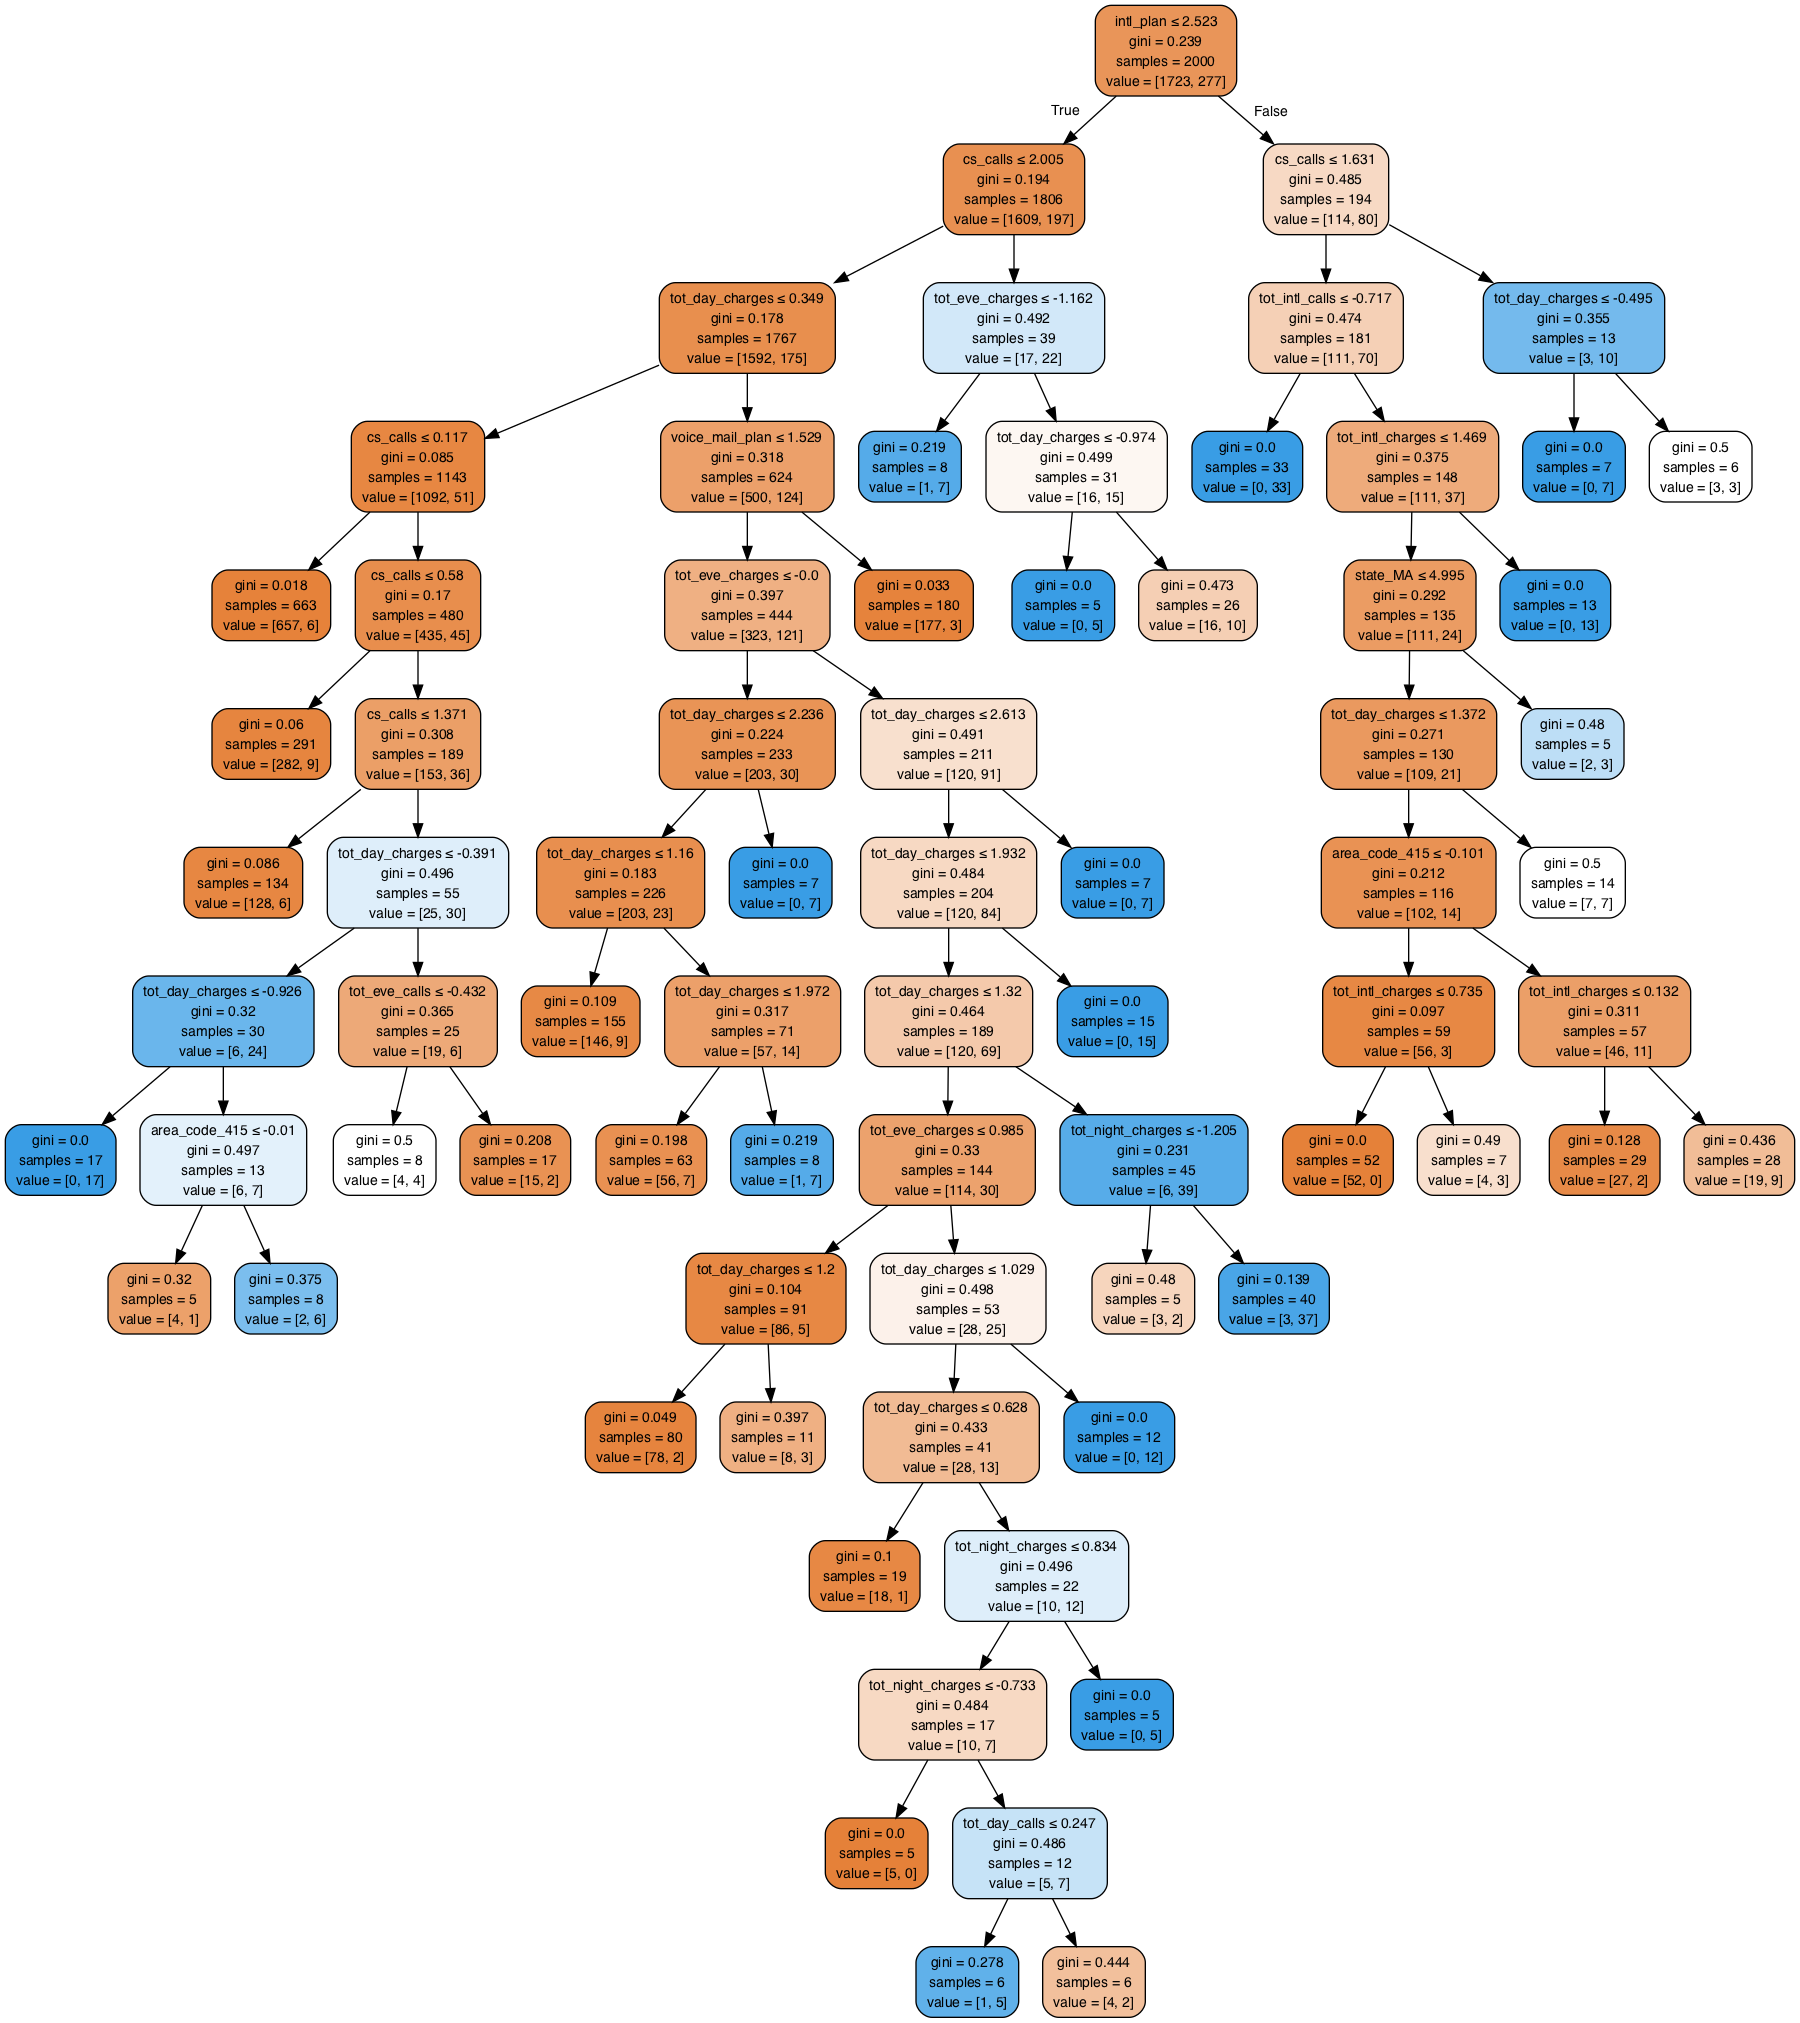

In [36]:
# ROC curve and tree visualization
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

acc_decision_tree_train = round(b_decision_tree.score(X_scaled_train, Y_train) * 100, 2)
print("Train precision: " ,acc_decision_tree_train)
acc_decision_tree_test = round(b_decision_tree.score(X_scaled_test, Y_test) * 100, 2)
print("Test precision: " ,acc_decision_tree_test)

fpr, tpr, thresholds = roc_curve(Y_test, b_decision_tree.predict_proba(X_scaled_test)[:,1])
decision_tree_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='Decision trees (AUC = %0.2f)' % decision_tree_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

dot_data = StringIO()
export_graphviz(b_decision_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
               feature_names = X_test.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [37]:
b_decision_tree.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=17,
            max_features=None, max_leaf_nodes=38,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')>

### Decision tree without location

In [38]:
# Dropping location 
X_train = train_df.drop(["state","area_code","churn","phone_num","tot_day_min","tot_night_min",
                         "tot_eve_min", "tot_intl_min"], axis=1)
X_test = test_df.drop(["state","area_code","churn","phone_num","tot_day_min","tot_night_min",
                         "tot_eve_min", "tot_intl_min"], axis=1)

X_scaled_train_2 = preprocessing.scale(X_train)
X_scaled_test_2 = preprocessing.scale(X_test)

In [43]:
# Logistic regression without area and voice mail data, validation set used
train_X_scaled_train_2, val_X_scaled_train_2, train_Y_train_2, val_Y_train_2 = train_test_split(X_scaled_train_2, Y_train,test_size=0.2)

depth = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
leaf_nodes = [10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
samples = [5,10,15,20]
split = [5,10,20,30,40,50]
b_auc = 0
b_decision_tree = 'NA'

for d in depth:
    for leaf in leaf_nodes:
        for sample in samples:
            for spl in split:
                decision_tree = DecisionTreeClassifier(max_depth = d, max_leaf_nodes= leaf,
                                                       min_samples_split=spl,splitter='random',
                                                      min_samples_leaf=sample)
                decision_tree.fit(train_X_scaled_train_2, train_Y_train_2)
                fpr, tpr, thresholds = roc_curve(val_Y_train_2, decision_tree.predict_proba(val_X_scaled_train_2)[:,1])
                decision_tree_auc = auc(fpr, tpr)
                if decision_tree_auc > b_auc:
                    b_decision_tree = decision_tree
                    b_auc = decision_tree_auc
                    
b_decision_tree.fit(X_scaled_train_2, Y_train_2)

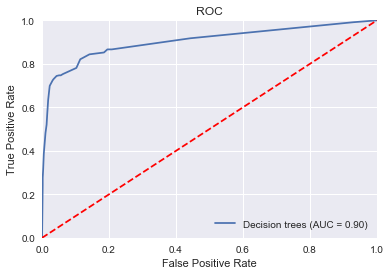

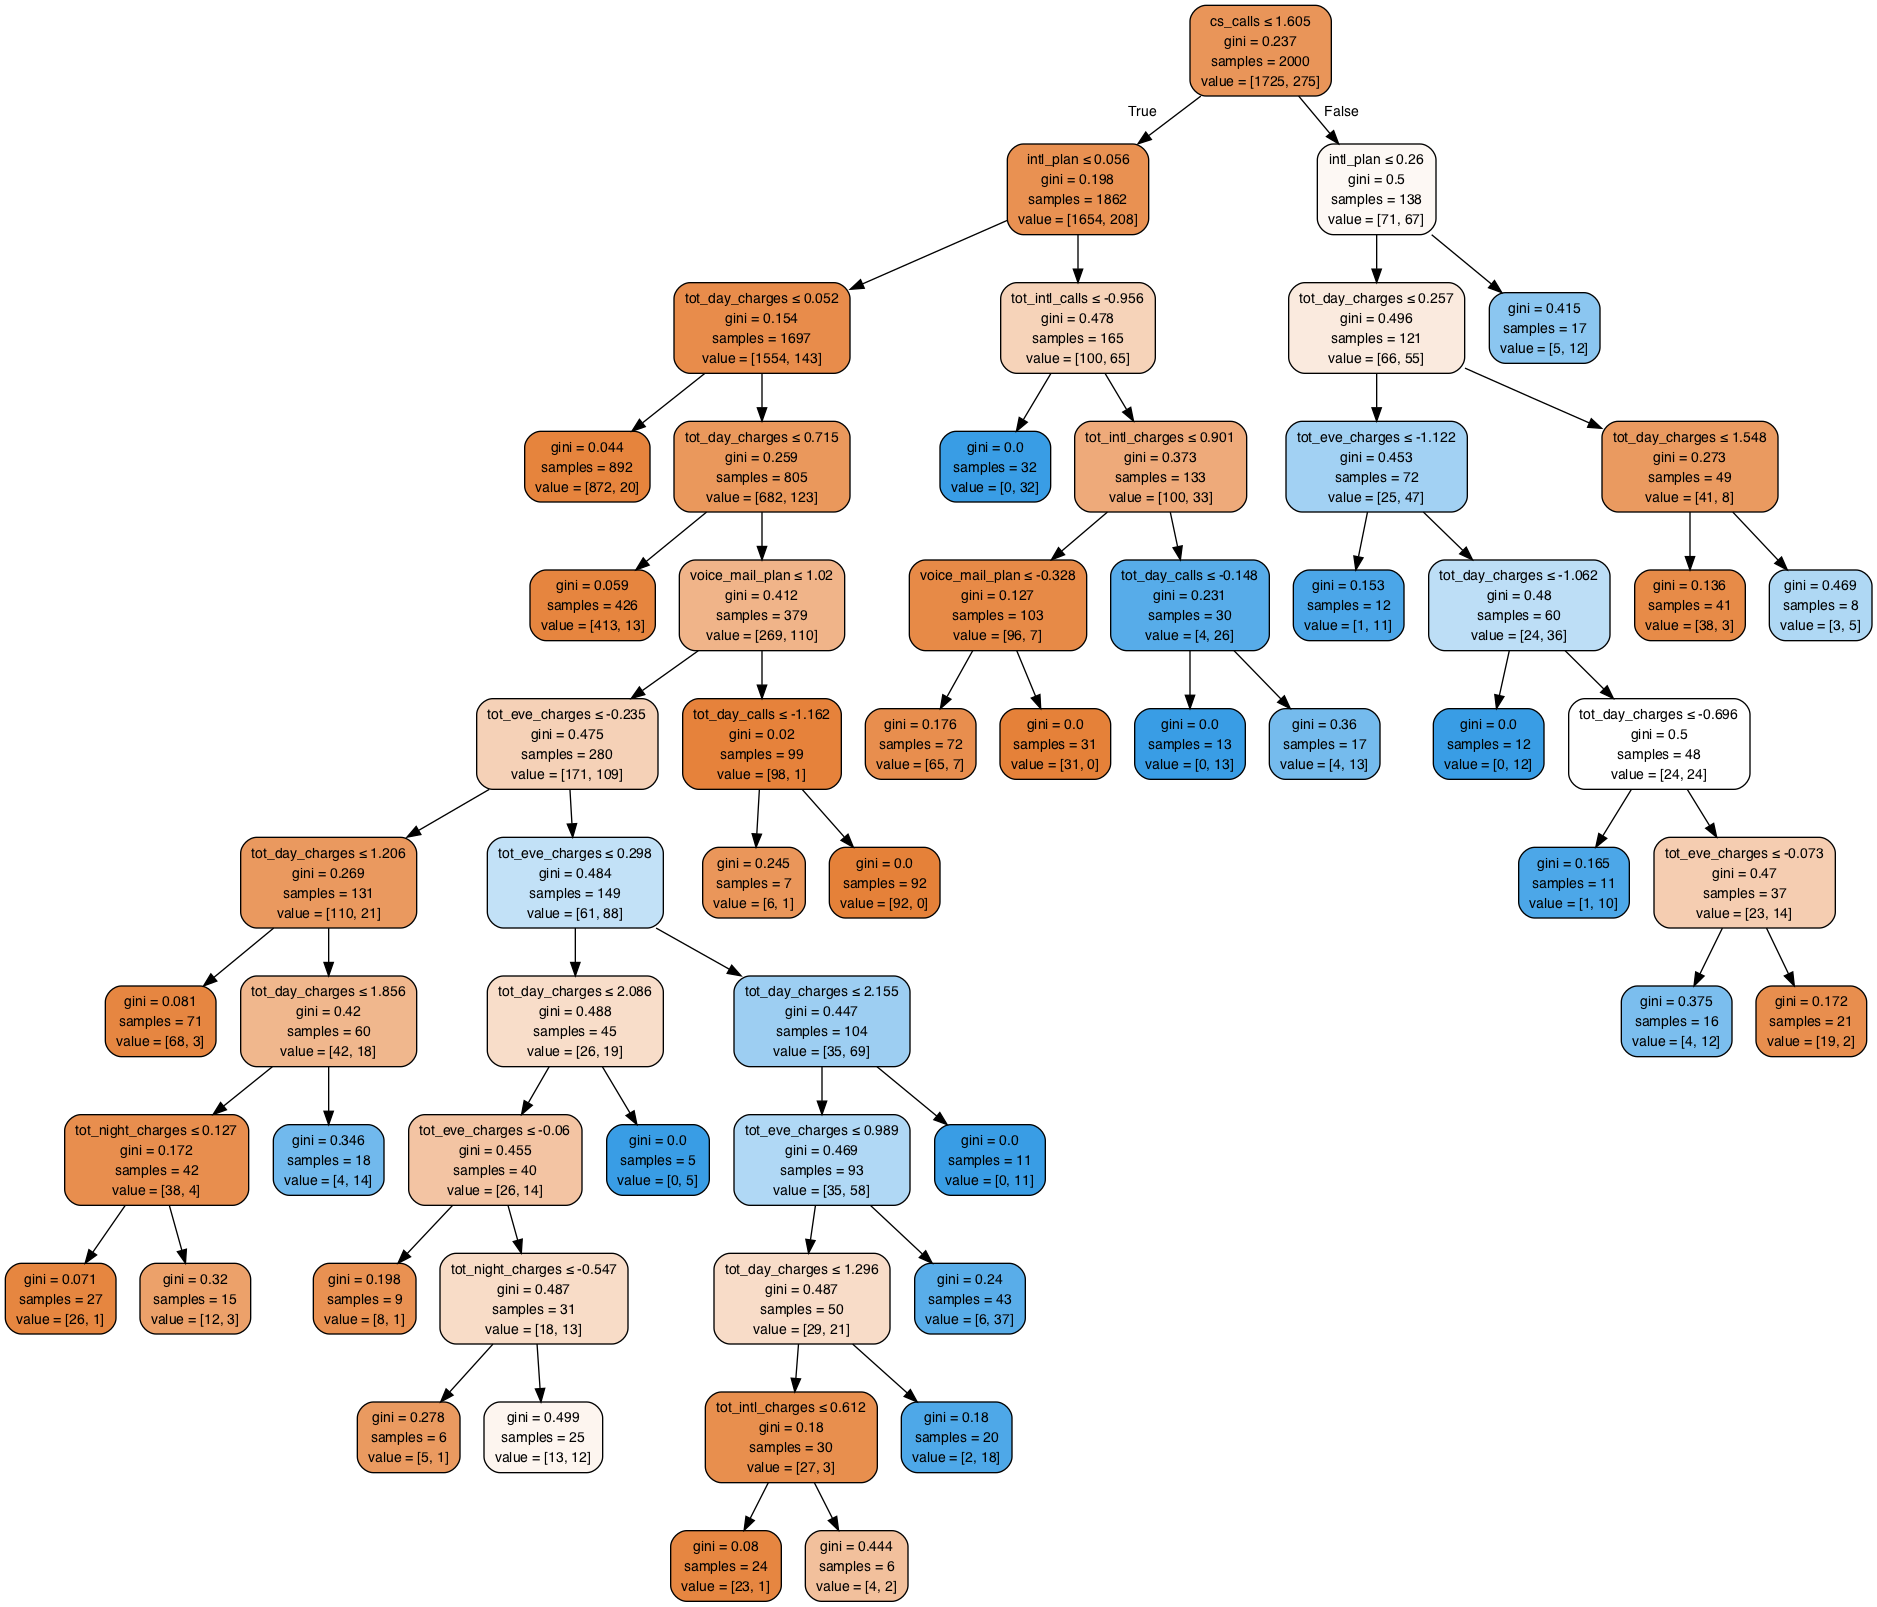

In [44]:
# ROC curve and tree visualization
fpr, tpr, thresholds = roc_curve(Y_test, b_decision_tree.predict_proba(X_scaled_test_2)[:,1])
decision_tree_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='Decision trees (AUC = %0.2f)' % decision_tree_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

dot_data = StringIO()
export_graphviz(b_decision_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
               feature_names = X_test.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


We can see that again strong features are number of customer support calls, international plan and charges. On the other hand, location, state and number of calls is probably not so important, because we were able to outperform previous model without including location data in our model. Using decision trees, we were able to get over threshold of 90% in terms of AUC.

### Random Forest
We also include more flexible model, which is trying to include not just strong but also other features, so this can result into better fit and as we can see, we obtained better performance than for Decision Tree. 

In [53]:
# Random forest with validation set for depth 

depth = [5,6,7,8,9,10,11,12,13]
leaf_nodes = [10,12,14,16,18,20,22]
samples = [5,10,15,20]
split = [5,10,20,30,40,50]
b_auc = 0
b_d = -1
b_random_forest = 'NA'
for d in depth:
    
    random_forest = RandomForestClassifier(n_estimators=1000, max_depth = d, max_features = "sqrt")
    random_forest.fit(train_X_scaled_train_2, train_Y_train_2)
    fpr, tpr, thresholds = roc_curve(val_Y_train_2, random_forest.predict_proba(val_X_scaled_train_2)[:,1])
    random_forest_auc = auc(fpr, tpr)
    if random_forest_auc > b_auc:
        b_random_forest = random_forest
        b_auc = random_forest_auc
        b_d = d


b_random_forest.fit(X_scaled_train_2, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Train precision:  96.44
Test precision:  93.32


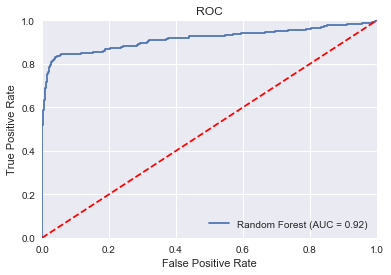

In [56]:
# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, b_random_forest.predict_proba(X_scaled_test_2)[:,1])
random_forest_auc = auc(fpr, tpr)

acc_random_forest_train = round(b_random_forest.score(X_scaled_train_2, Y_train) * 100, 2)
print("Train precision: " ,acc_random_forest_train)
acc_random_forest_test = round(b_random_forest.score(X_scaled_test_2, Y_test) * 100, 2)
print("Test precision: " ,acc_random_forest_test)

plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % random_forest_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### XGBoost
As the last model, we picked winner of the multiple Kaggle competitions, also tree based method, gradient boost tree algorithm, which usually does very well on classification problem with this structure. It fits small trees in sequence. It showed up that this model has the best performance among our models, even without parameters optimization we got high precision with the best AUC.

In [19]:
# XGBoost
xgboost = XGBClassifier()
xgboost.fit(X_scaled_train_2, Y_train)                     
xgboost.score(X_scaled_train_2, Y_train)
acc_xgboost_train = round(xgboost.score(X_scaled_train_2, Y_train) * 100, 2)
print("Train precision: " ,acc_xgboost_train)
acc_xgboost_test = round(xgboost.score(X_scaled_test_2, Y_test) * 100, 2)
print("Test precision: " ,acc_xgboost_test)

Train precision:  96.8
Test precision:  95.68


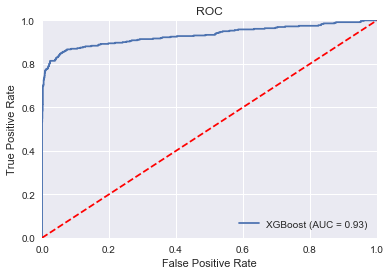

In [23]:
fpr, tpr, thresholds = roc_curve(Y_test, xgboost.predict_proba(X_scaled_test_2)[:,1])
xgboost_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (AUC = %0.2f)' % xgboost_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [4]:
print(res)

                 Model Area Under Curve
0  Logistic regression              81%
1      Decision Tree 1              89%
2      Decision Tree 2              90%
3        Random Forest              92%
4              XGBoost              93%


# Recommendations
Based on our model/models we can see that strong features, which drive churn are mainly international plan, charges (mostly daily) and customer service calls. Thus, this company should pay attention on customers who call customer service a lot, because they are probably not satisfied, also highly paying customers for which they can probably offer some kind of discount or special offer in order to preserve them. In addition, international plan is probably too expensive comparing to competitors, because customers with international plan are more likely to do the churn, so this company should also think about this. On the other hand, voice mail has positive effect on preserving customers, so probably this would be good benefit. 

In terms of prediction, I would recommend to use the most precise model XGBoost and according its predictions, our client should closer look onto each single customer, which is likely to do the churn and try to "save" him/her.

## Remarks

We always have to take into account that quality of our model depends on our assumptions about data, true relationship of features with response and quality of our data. Thus, there is no single model which is the best one for every single case and we have to always choose one according to our goal and assumptions. Plus, every model is just as good as our assumption. We dropped several features, because we always want to make our model as simple as possible, but no simpler.
